# Advanced Tutorial 13: Multi-Dataset Training and Evaluation

## Overview
In this tutorial, we will discuss the following topics:

* [Multi-Dataset Concept and API](#ta13multidsapi)
    * [Adding multiple datasets to a pipeline](#ta13multidspipe)
    * [Dataset-specific Ops](#ta13dsspecificops)
    * [Dataset-specific Traces](#ta13dsspecifictrace)
    * [Specifying multiple datasets in Ops or Traces](#ta13multidsoptrace)
* [Multi-dataset Example](#ta13example)

<a id='ta13multidsapi'></a>

## Multi-Dataset Concept and API
When you are training a deep learning model, you may sometimes want to train/evaluate on multiple datasets. For example, we might be interested in knowing evaluation metrics separately for two datasets. In this section we show how to do that conveniently in FastEstimator. 

<a id='ta13multidspipe'></a>

### Adding multiple datasets to a Pipeline
If you have multiple datasets, then in `Pipeline` you can simply provide a dictionary to the `train_data`, `eval_data`, and/or `test_data` arguments, with keys being the names of the datasets and values being the data instances.

For example:
```python
pipeline = fe.Pipeline(eval_data={"ds1": eval_data1, "ds2": eval_data2}, ...)
```

In the above example, `ds1` and `ds2` are the names of those datasets. These can be any other arbitrary names.

<a id='ta13dsspecificops'></a>

### Dataset-specific Ops
Sometimes different datasets might require specific NumpyOps or TensorOps. For example, when we train a gray-scale model and have both gray-scale and colored evaluation sets, we only need to apply the gray-scale conversion to the colored dataset.

In FastEstimator, To indicate that an Op is only applied for a specific dataset (say `ds1`), one only needs to do:
```python
Op(..., ds_id="ds1") # run the op on ds1
```

`ds_id` works similarly to the `mode` argument in Ops. The operator will only execute if `ds_id` matches the specific dataset. If `ds_id` is None (default), then it will execute on all datasets.

The `ds_id` argument works in conjunction with `mode`. For example, `Op(mode="train", ds_id="myds1")` would only run during training for dataset named "myds1".

<a id='ta13dsspecifictrace'></a>

### Dataset-specific Traces

To only execute a Trace for a specific dataset, simply pass:
```python
Trace(..., ds_id="ds1") # run the trace on ds1
```

When using multiple datasets, the built-in FastEstimator metric traces will automatically report their outputs for each dataset individually, as well as the overall metric aggregated over all datasets. We will demonstrate this behavior in detail in the example section.

<a id='ta13multidsoptrace'></a>

### Specifying multiple datasets in Ops or Traces
When an Op or Trace needs to execute on multiple datasets, simply provide a list, tuple, or set of dataset names to the `ds_id` argument. 

For example:
```python
Op(..., ds_id=["ds1", "ds2"])  # run on both ds1 and ds2
```

When there are many datasets such that listing every name becomes undesirable, you can use `!` in front of the dataset name to indicate `all except`. 

For example:
```python
Op(..., ds_id=["!ds1", "!ds2"])  # run on all datasets except ds1 and ds2
```


<a id='ta13example'></a>

## Multi-dataset Example

In this example, we will train on the MNIST dataset but evaluate on both the MNIST test set and the SVHN-Cropped test set. Here are the dataset-specific items we will do in this example:
* Resize images in the SVHN-Cropped dataset from 32x32 to 28x28 to match the MNIST data
* Convert the SVHN-Cropped dataseet to gray-scale
* Measure dataset-specific Accuracy as well as combined Accuracy
* Customize an AUC metric that works on a per-dataset level
* Save the best model based on evaluation AUC of a specific dataset

### Prepare Dataset

In [1]:
from fastestimator.dataset.data import mnist, svhn_cropped

train_mnist, eval_mnist = mnist.load_data()
_, eval_svhn = svhn_cropped.load_data()
print("mnist evaluation dataset summary:")
print(eval_mnist.summary())

print("svhn_cropped evaluation dataset summary:")
print(eval_svhn.summary())

mnist evaluation dataset summary:
{"num_instances": 10000, "keys": {"x": {"shape": [28, 28], "dtype": "uint8"}, "y": {"num_unique_values": 10, "shape": [], "dtype": "uint8"}}}
svhn_cropped evaluation dataset summary:
{"num_instances": 26032, "keys": {"x": {"shape": [32, 32, 3], "dtype": "uint8"}, "y": {"shape": [1], "dtype": "uint8"}}}


### Preprocessing

In [2]:
import fastestimator as fe
from fastestimator.op.numpyop.univariate import ExpandDims, Minmax, ToGray
from fastestimator.op.numpyop.multivariate import Resize
from fastestimator.op.numpyop import LambdaOp

pipeline = fe.Pipeline(train_data={"mnist": train_mnist}, 
                       eval_data={"mnist": eval_mnist, "svhn": eval_svhn},
                       batch_size=32,
                       ops= [
                             Resize(image_in="x", image_out="x", height=28, width=28, ds_id="svhn"),
                             ToGray(inputs="x", outputs="x", ds_id="svhn"), # after ToGray, the output is still 3 channel
                             LambdaOp(fn=lambda x: x[..., 0:1], inputs="x", outputs="x", ds_id="svhn"), # select the first channel for svhn
                             ExpandDims(inputs="x", outputs="x", ds_id="mnist"), # (28, 28) -> (28, 28, 1) for mnist
                             Minmax(inputs="x", outputs="x")])

### Visualize MNIST preprocessing results

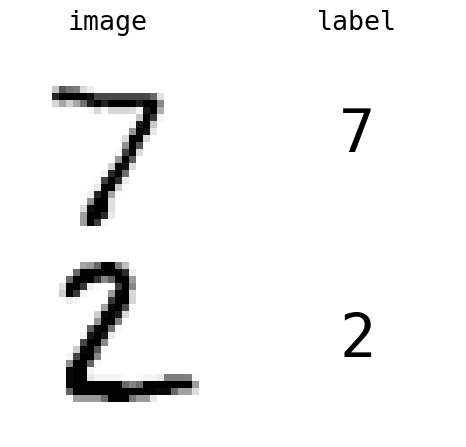

In [3]:
mnist_eval_data = pipeline.get_results(mode="eval", ds_id="mnist")
img = fe.util.ImgData(image=mnist_eval_data["x"][:2].numpy(), label=mnist_eval_data["y"][:2].numpy())
fig = img.paint_figure()

### Visualize SVHN_cropped preprocessing results

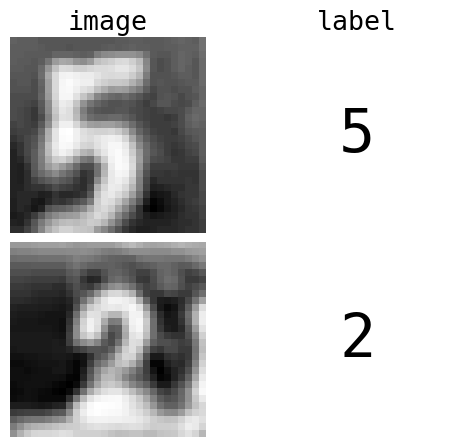

In [4]:
svhn_eval_data = pipeline.get_results(mode="eval", ds_id="svhn")
img = fe.util.ImgData(image=svhn_eval_data["x"][:2].numpy(), label=svhn_eval_data["y"][:2].numpy())
fig = img.paint_figure()

### Define Model and Networks

In [5]:
from fastestimator.architecture.tensorflow import LeNet
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp

model = fe.build(model_fn=LeNet, optimizer_fn="adam")
network = fe.Network(ops=[
        ModelOp(model=model, inputs="x", outputs="y_pred"),
        CrossEntropy(inputs=("y_pred", "y"), outputs="ce"),
        UpdateOp(model=model, loss_name="ce")
    ])

### Start Training with Only Accuracy Trace

In [6]:
from fastestimator.trace.io import BestModelSaver
from fastestimator.trace.metric import Accuracy


estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=4,
                         traces=Accuracy(true_key="y", pred_key="y_pred"),
                         train_steps_per_epoch=200)

estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Warn: No ModelSaver Trace detected. Models will not be saved.
FastEstimator-Start: step: 1; logging_interval: 100; num_device: 0;
FastEstimator-Train: step: 1; ce: 2.3098626;
FastEstimator-Train: step: 100; ce: 0.36128625; steps/sec: 67.33;
FastEstimator-Train: step: 200; ce: 0.119157925; steps/sec: 66.83;
FastEstimator-Train: step: 200; epoch: 1; epoch_time: 4.57 sec;
FastEstimator-Eval: step: 200; epoch: 1; accuracy: 0.8371170071047958; accuracy|mnist: 0.9494; accuracy|svhn: 0.7939843269821758; ce: 0.52921724;
FastEstimator-Train: step: 30

As you can see in the training log, the `Accuracy` Trace created 3 keys: `accuracy|mnist`, `accuracy|svhn`, and `accuracy`. The `accuracy|mnist` and `accuracy|svhn` are measured on individual datasets, and `accuracy` is measured on the overall combined evaluation set.

### Customize an AUC metric that works for every dataset, then save model based on AUC of a specific dataset

Since this is a 10-class classification task, to simplify AUC calculation, we will count any label < 5 as 0 and the rest of labels as 1.  When a trace is initializing the data during `on_epoch_begin` and outputting the data during `on_epoch_end`, we only need a `per_ds` decorator to enable multi-dataset support as shown below.

In [7]:
from fastestimator.trace.meta.per_ds import per_ds
from sklearn import metrics
import numpy as np


@per_ds  # Without this annotation the trace would only compute the aggregate metric
class AUC(fe.trace.Trace):
    def on_epoch_begin(self, data):
        self.y_true = []
        self.y_pred = []

    def on_batch_end(self, data):
        y_pred, y_true = np.argmax(data["y_pred"].numpy(), axis=-1), data["y"].numpy()
        y_pred, y_true = np.where(y_pred < 5, 0, 1), np.where(y_true < 5, 0, 1)
        self.y_pred.extend(y_pred.ravel())
        self.y_true.extend(y_true.ravel())

    def on_epoch_end(self, data):
        fpr, tpr, _ = metrics.roc_curve(self.y_true, self.y_pred)
        auc = metrics.auc(fpr, tpr)
        data.write_with_log("auc", auc)

In [8]:
import tempfile
from fastestimator.trace.io import BestModelSaver

estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=4,
                         traces=[Accuracy(true_key="y", pred_key="y_pred"), 
                                 AUC(inputs=("y", "y_pred"), outputs="auc", mode="eval"),
                                 BestModelSaver(model=model, save_dir=tempfile.mkdtemp(), metric="auc|svhn", save_best_mode="max")],
                         train_steps_per_epoch=200)

estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; logging_interval: 100; num_device: 0;
FastEstimator-Train: step: 1; ce: 0.17271854;
FastEstimator-Train: step: 100; ce: 0.012849649; steps/sec: 55.68;
FastEstimator-Train: step: 200; ce: 0.001781; steps/sec: 55.39;
FastEstimator-Train: step: 200; epoch: 1; epoch_time: 4.0 sec;
FastEstimator-BestModelSaver: Saved model to /var/folders/3r/h9kh47050gv6rbt_pgf8cl540000gn/T/tmpqpqftot6/model_best_auc|svhn.h5
FastEstimator-Eval: step: 200; epoch: 1; accuracy: 0.9495448490230906; accuracy|mnist: 0.9907; accuracy|svhn: 0.933735402581

Now during evaluation we can see `auc|svhn`, `auc|mnist`, and `auc` printing in the log. Moreover, our model saving is based on the best evaluation auc on the svhn dataset.